In [1]:
%env SPARK_DRIVER_MEMORY=10g

env: SPARK_DRIVER_MEMORY=10g


# Image Segmentation with `tf.keras` and TFPark

Note: This tutorial is ported from https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb

In this tutorial we will learn how to segment images. **Segmentation** is the process of generating pixel-wise segmentations giving the class of the object visible at each pixel. For example, we could be identifying the location and boundaries of people within an image or identifying cell nuclei from an image. Formally, image segmentation refers to the process of partitioning an image into a set of pixels that we desire to identify (our target) and the background. 

Specifically, in this tutorial we will be using the [Kaggle Carvana Image Masking Challenge Dataset](https://www.kaggle.com/c/carvana-image-masking-challenge). 

This dataset contains a large number of car images, with each car taken from different angles. In addition, for each car image, we have an associated manually cutout mask; our task will be to automatically create these cutout masks for unseen data. 

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts:
* **[Functional API](https://keras.io/getting-started/functional-api-guide/)** - we will be implementing UNet, a convolutional network model classically used for biomedical image segmentation with the Functional API. 
  * This model has layers that require multiple input/outputs. This requires the use of the functional API
  * Check out the original [paper](https://arxiv.org/abs/1505.04597), 
U-Net: Convolutional Networks for Biomedical Image Segmentation by Olaf Ronneberger!
* **Custom Loss Functions and Metrics** - We'll implement a custom loss function using binary [**cross entropy**](https://developers.google.com/machine-learning/glossary/#cross-entropy) and **dice loss**. We'll also implement **dice coefficient** (which is used for our loss) and **mean intersection over union**, that will help us monitor our training process and judge how well we are performing.  

### We will follow the general workflow:
1. Visualize data/perform some exploratory data analysis
2. Set up data pipeline and preprocessing
3. Build model
4. Train model
5. Evaluate model
6. Repeat

**Audience:** This post is geared towards intermediate users who are comfortable with basic machine learning concepts.

**Time Estimated**: 60 min

In [2]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [3]:
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from zoo import init_nncontext 
sc = init_nncontext()

# Get all the files 
You **should manually download** the dataset from kaggle [carvana-image-masking-challenge](https://www.kaggle.com/c/carvana-image-masking-challenge/data) and put it to the following path. We will need three files, `train.zip`, `train_mask.zip` and `train_mask.csv.zip`

In [4]:
file_path = '/tmp/carvana/'

In [5]:
# Download data from Kaggle and unzip the files of interest. 
def load_data_from_zip(file_path, file):
    with zipfile.ZipFile(os.path.join(file_path, file), "r") as zip_ref:
        unzipped_file = zip_ref.namelist()[0]
        zip_ref.extractall(file_path)

def load_data(file_path):
    load_data_from_zip(file_path, 'train.zip')
    load_data_from_zip(file_path, 'train_masks.zip')
    load_data_from_zip(file_path, 'train_masks.csv.zip')

In [6]:
load_data(file_path)

In [7]:
img_dir = os.path.join(file_path, "train")
label_dir = os.path.join(file_path, "train_masks")

Here we only takes the first 1000 files for simplicity. You can use all images if you have enough computation resources.

In [8]:
df_train = pd.read_csv(os.path.join(file_path, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])
ids_train = ids_train[:1000]

In [9]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [10]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [11]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 800
Number of validation examples: 200


### Here's what the paths look like 

In [12]:
x_train_filenames[:10]

['/tmp/carvana/train/02159e548029_14.jpg',
 '/tmp/carvana/train/1adaeb44f109_08.jpg',
 '/tmp/carvana/train/23c088f6ec27_08.jpg',
 '/tmp/carvana/train/1ae8a68a40e4_14.jpg',
 '/tmp/carvana/train/2a4a8964ebf3_05.jpg',
 '/tmp/carvana/train/1c5748340af8_05.jpg',
 '/tmp/carvana/train/0d1a9caf4350_06.jpg',
 '/tmp/carvana/train/2ea62c1beee7_07.jpg',
 '/tmp/carvana/train/1952e5f91de0_16.jpg',
 '/tmp/carvana/train/2990f858e939_09.jpg']

In [13]:
y_train_filenames[:10]

['/tmp/carvana/train_masks/02159e548029_14_mask.gif',
 '/tmp/carvana/train_masks/1adaeb44f109_08_mask.gif',
 '/tmp/carvana/train_masks/23c088f6ec27_08_mask.gif',
 '/tmp/carvana/train_masks/1ae8a68a40e4_14_mask.gif',
 '/tmp/carvana/train_masks/2a4a8964ebf3_05_mask.gif',
 '/tmp/carvana/train_masks/1c5748340af8_05_mask.gif',
 '/tmp/carvana/train_masks/0d1a9caf4350_06_mask.gif',
 '/tmp/carvana/train_masks/2ea62c1beee7_07_mask.gif',
 '/tmp/carvana/train_masks/1952e5f91de0_16_mask.gif',
 '/tmp/carvana/train_masks/2990f858e939_09_mask.gif']

# Visualize
Let's take a look at some of the examples of different images in our dataset. 

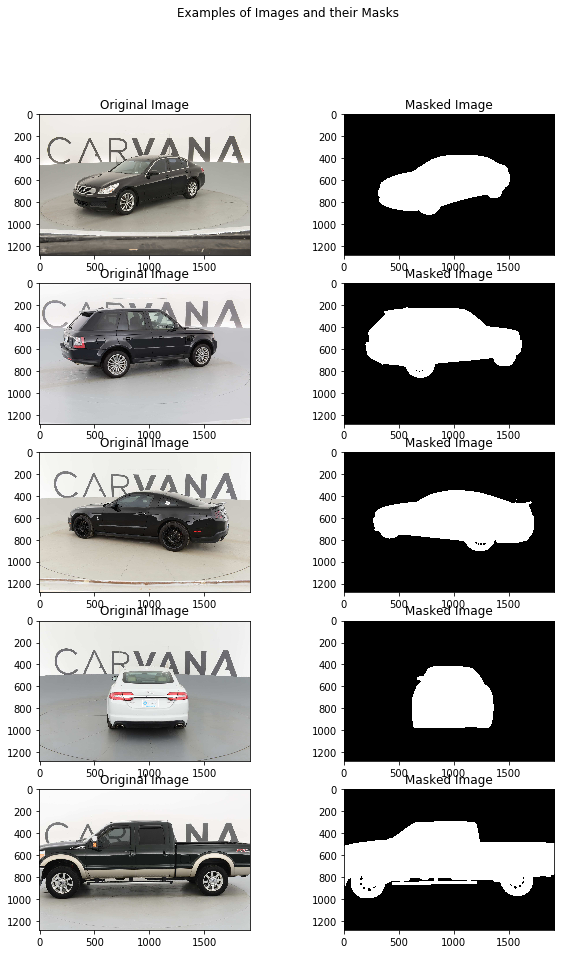

In [14]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]
  
    plt.subplot(display_num, 2, i + 1)
    plt.imshow(mpimg.imread(x_pathname))
    plt.title("Original Image")
  
    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)
  
    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

# Set up 

Let’s begin by setting up some parameters. We’ll standardize and resize all the shapes of the images. We’ll also set up some training parameters.

In [15]:
img_shape = (128, 128, 3)
batch_size = 8
epochs = 7

Here we resize the image to 128 x 128 to reduce the running time and memory overhead. You can can get better result by using higher resolution images. Also, it is important to note that due to the architecture of our UNet version, the size of the image must be evenly divisible by a factor of 32, as we down sample the spatial resolution by a factor of 2 with each `MaxPooling2Dlayer`.


If your machine can support it, you will achieve better performance using a higher resolution input image (e.g. 512 by 512) as this will allow more precise localization and less loss of information during encoding. In addition, you can also make the model deeper.


Alternatively, if your machine cannot support it, lower the image resolution and/or batch size. Note that lowering the image resolution will decrease performance and lowering batch size will increase training time.


# Build our input pipeline with PySpark and `TFDataset`
Since we begin with filenames, we will need to build a robust and scalable data pipeline that will play nicely with our model. 

## Processing each pathname

In [16]:
from scipy import misc
def load_and_process_image(file_path):
    array = mpimg.imread(file_path)
    result = np.array(array)
    result = misc.imresize(result, size=(128, 128))
    result = result.astype(float)
    result /= 255.0
    return result

def load_and_process_image_label(file_path):
    array = mpimg.imread(file_path)
    result = np.array(array)
    result = misc.imresize(result, size=(128, 128))
    result = np.expand_dims(result[:, :, 1], axis=-1)
    result = result.astype(float)
    result /= 255.0
    return result
    
train_images = sc.parallelize(x_train_filenames).map(lambda filepath: load_and_process_image(filepath))
train_label_images = sc.parallelize(y_train_filenames).map(lambda filepath: load_and_process_image_label(filepath))

In [17]:
val_images = np.stack([load_and_process_image(filepath) for filepath in x_val_filenames])
val_label_images = np.stack([load_and_process_image_label(filepath) for filepath in y_val_filenames])

/home/yang/anaconda3/envs/az_py_36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """
/home/yang/anaconda3/envs/az_py_36/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


In [18]:
val_images.shape, val_label_images.shape

((200, 128, 128, 3), (200, 128, 128, 1))

In [19]:
from zoo.tfpark import *
train_rdd = train_images.zip(train_label_images)

dataset = TFDataset.from_rdd(train_rdd,
                             features=(tf.float32, [128, 128, 3]),
                             labels=(tf.float32, [128, 128, 1]),
                             batch_size=batch_size)

# Build the model
We'll build the U-Net model. U-Net is especially good with segmentation tasks because it can localize well to provide high resolution segmentation masks. In addition, it works well with small datasets and is relatively robust against overfitting as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself. Unlike the original model, we will add batch normalization to each of our blocks. 

The Unet is built with an encoder portion and a decoder portion. The encoder portion is composed of a linear stack of [`Conv`](https://developers.google.com/machine-learning/glossary/#convolution), `BatchNorm`, and [`Relu`](https://developers.google.com/machine-learning/glossary/#ReLU) operations followed by a [`MaxPool`](https://developers.google.com/machine-learning/glossary/#pooling). Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale. 
## The Keras Functional API
The Keras functional API is used when you have multi-input/output models, shared layers, etc. It's a powerful API that allows you to manipulate tensors and build complex graphs with intertwined datastreams easily. In addition it makes **layers** and **models** both callable on tensors. 
  * To see more examples check out the [get started guide](https://keras.io/getting-started/functional-api-guide/). 
  
  
  We'll build these helper functions that will allow us to ensemble our model block operations easily and simply. 

In [20]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

In [21]:
inputs = layers.Input(shape=(128, 128, 3))
# 128

encoder0_pool, encoder0 = encoder_block(inputs, 16)
# 64

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 32)
# 32

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 64)
# 16

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 128)
# 8

center = conv_block(encoder3_pool, 256)
# center

decoder3 = decoder_block(center, encoder3, 128)
# 16

decoder2 = decoder_block(decoder3, encoder2, 64)
# 32

decoder1 = decoder_block(decoder2, encoder1, 32)
# 64

decoder0 = decoder_block(decoder1, encoder0, 16)
# 128

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

## Define your model
Using functional API, you must define your model by specifying the inputs and outputs associated with the model. 

In [22]:
net = models.Model(inputs=[inputs], outputs=[outputs])

# Defining custom metrics and loss functions
Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example. 

Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced. 

We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly. 

In [23]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [24]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

Here, we'll use a specialized loss function that combines binary cross entropy and our dice loss. This is based on [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). Try out your own custom losses to measure performance (e.g. bce + log(dice_loss), only bce, etc.)!

In [25]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Compile your model
We use our custom loss function to minimize. In addition, we specify what metrics we want to keep track of as we train. Note that metrics are not actually used during the training process to tune the parameters, but are instead used to measure performance of the training process. 

In [26]:
net.compile(optimizer=tf.keras.optimizers.Adam(2e-3), loss=bce_dice_loss)

net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        activation[0][0]                 
__________________________________________________________________________________________________
activation

## Train your model

In [27]:
keras_model = KerasModel(net)

In [28]:
keras_model.fit(dataset, epochs=epochs)

creating: createAdam
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 46 variables.
INFO:tensorflow:Converted 46 variables to const ops.
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createMaxEpoch


# Visualize actual performance 
We'll visualize our performance on the validation set.

Note that in an actual setting (competition, deployment, etc.) we'd evaluate on the test set with the full image resolution. 

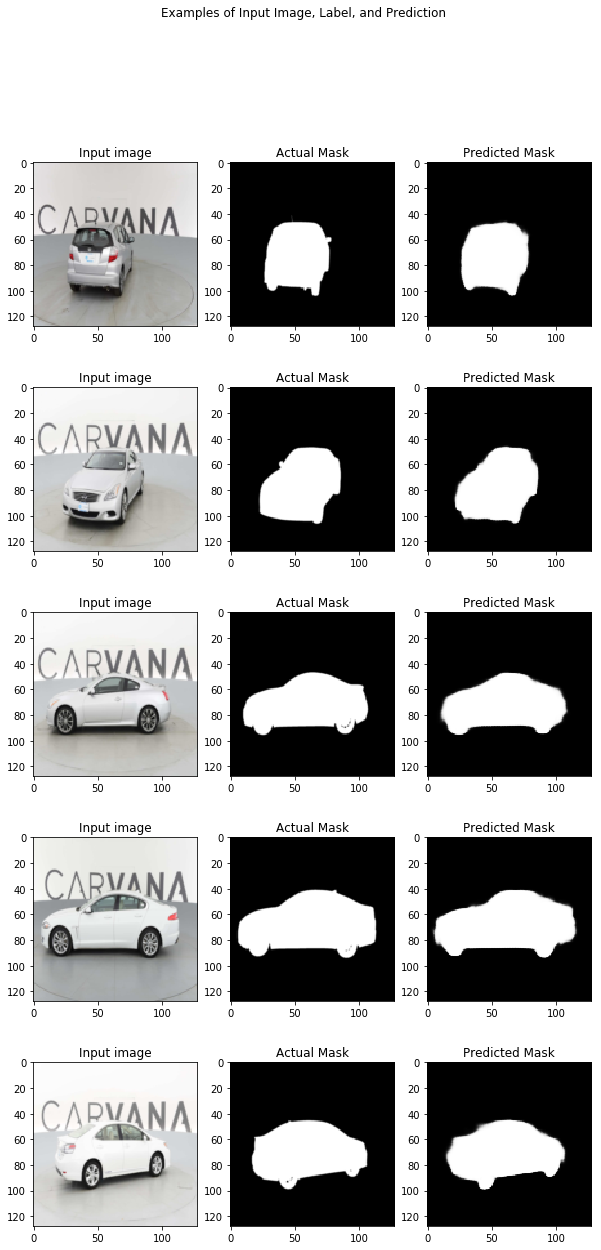

In [29]:
# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    img, label = val_images[i], val_label_images[i]
    batch_img = np.expand_dims(img, axis=0)
    predicted_label = keras_model.predict(batch_img)[0]

    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title("Input image")
  
    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(label[:, :, 0], cmap='gray')
    plt.title("Actual Mask")
    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(predicted_label[:, :, 0], cmap='gray')
    plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()